# Dog Breeds Classifier

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
# mkdir ./data/dogbreeeds
# kg download -u <username> -p <password> -c dog-breed-identification

In [3]:
PATH = './data/dogbreeds/'
sz=224
arch=resnext101_64 
bs=32

In [4]:
label_csv = f'{PATH}labels.csv'

n = len(list(open(label_csv)))-1

val_idxs = get_cv_idxs(n)

# Initial Exploration

In [5]:
n

10222

In [6]:
len(val_idxs)

2044

In [7]:
len(val_idxs)/n   # 20%

0.19996086871453728

In [8]:
os.listdir(PATH)

google		models			   submmission.gz  tmp
labels.csv	sample_submission.csv	   test		   train
labels.csv.zip	sample_submission.csv.zip  test.zip	   train.zip


In [9]:
label_df = pd.read_csv(label_csv)

In [10]:
label_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [11]:
label_df.pivot_table(index='breed', aggfunc=len).sort_values('id', ascending=False)

,id
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
shih-tzu,112
great_pyrenees,111
pomeranian,111
basenji,110


In [12]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH, 'train' ,f'{PATH}labels.csv', test_name='test', 
                                    val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)

In [13]:
fn = PATH + data.trn_ds.fnames[0]
fn

'./data/dogbreeds/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg'

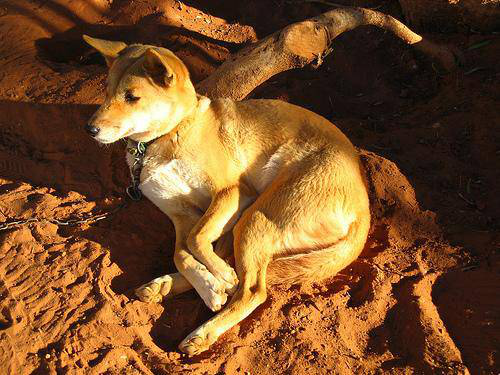

In [14]:
img = Image.open(fn)
img

In [15]:
img.size

(500, 375)

In [16]:
size_d = {k: Image.open(PATH+k).size for k in data.trn_ds.fnames}

In [17]:
row_sz, col_sz = list(zip(*size_d.values()))

In [18]:
row_sz = np.array(row_sz)
col_sz = np.array(col_sz)

In [19]:
row_sz[:5]

array([500, 500, 500, 500, 500])

(array([3023., 5024.,   92.,   15.,    5.,    3.,   13.,    2.,    0.,    1.]),
 array([  97. ,  413.7,  730.4, 1047.1, 1363.8, 1680.5, 1997.2, 2313.9, 2630.6, 2947.3, 3264. ]),
 <a list of 10 Patch objects>)

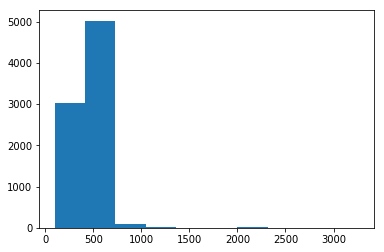

In [20]:
plt.hist(row_sz)

(array([ 135.,  592., 1347., 1164., 4599.,  128.,   76.,   62.,   14.,   11.]),
 array([ 97. , 185.5, 274. , 362.5, 451. , 539.5, 628. , 716.5, 805. , 893.5, 982. ]),
 <a list of 10 Patch objects>)

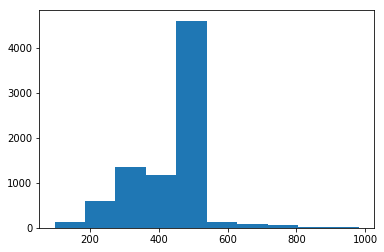

In [21]:
plt.hist(row_sz[row_sz<1000]) 

(array([2870., 5121.,  128.,   25.,   10.,   15.,    5.,    2.,    0.,    2.]),
 array([ 102.,  348.,  594.,  840., 1086., 1332., 1578., 1824., 2070., 2316., 2562.]),
 <a list of 10 Patch objects>)

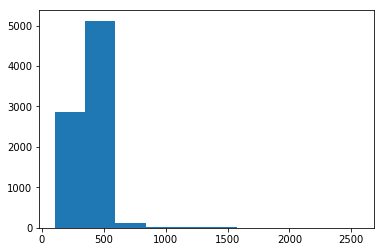

In [22]:
plt.hist(col_sz)

(array([ 235.,  733., 2205., 2979., 1807.,   98.,   27.,   33.,    7.,   10.]),
 array([102., 190., 278., 366., 454., 542., 630., 718., 806., 894., 982.]),
 <a list of 10 Patch objects>)

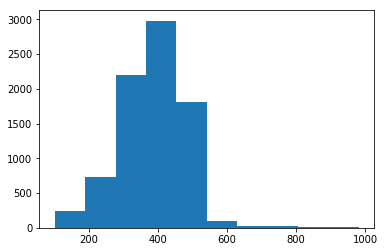

In [23]:
plt.hist(col_sz[col_sz<1000])

In [24]:
len(data.trn_ds), len(data.test_ds)

(8178, 10357)

In [25]:
len(data.classes), data.classes[:]

(120,
 ['affenpinscher',
  'afghan_hound',
  'african_hunting_dog',
  'airedale',
  'american_staffordshire_terrier',
  'appenzeller',
  'australian_terrier',
  'basenji',
  'basset',
  'beagle',
  'bedlington_terrier',
  'bernese_mountain_dog',
  'black-and-tan_coonhound',
  'blenheim_spaniel',
  'bloodhound',
  'bluetick',
  'border_collie',
  'border_terrier',
  'borzoi',
  'boston_bull',
  'bouvier_des_flandres',
  'boxer',
  'brabancon_griffon',
  'briard',
  'brittany_spaniel',
  'bull_mastiff',
  'cairn',
  'cardigan',
  'chesapeake_bay_retriever',
  'chihuahua',
  'chow',
  'clumber',
  'cocker_spaniel',
  'collie',
  'curly-coated_retriever',
  'dandie_dinmont',
  'dhole',
  'dingo',
  'doberman',
  'english_foxhound',
  'english_setter',
  'english_springer',
  'entlebucher',
  'eskimo_dog',
  'flat-coated_retriever',
  'french_bulldog',
  'german_shepherd',
  'german_short-haired_pointer',
  'giant_schnauzer',
  'golden_retriever',
  'gordon_setter',
  'great_dane',
  'great

# Initial Model

In [26]:
def get_data(sz, bs, val):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train' ,f'{PATH}labels.csv', test_name='test', num_workers=4, 
                                        val_idxs=val, suffix='.jpg', tfms=tfms, bs=bs)
    return data #if sz > 300 else data.resize(340, 'tmp')

# Fit Model and Toggle Precompute

In [27]:
data = get_data(sz,bs,val_idxs)

In [29]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 162/162 [05:08<00:00,  1.90s/it]


In [30]:
learn.fit(1e-2, 3)

epoch      trn_loss   val_loss   accuracy                   
    0      0.994585   0.386017   0.917319  
    1      0.436129   0.300711   0.919276                    
    2      0.303203   0.262591   0.924168                    
    3      0.23473    0.25271    0.921722                    
    4      0.185734   0.24503    0.924658                    



[array([0.24503]), 0.9246575347131479]

In [28]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)  # adjust for dropout probability

In [32]:
learn.fit(1e-2,2)

epoch      trn_loss   val_loss   accuracy                   
    0      1.211884   0.430061   0.906556  
    1      0.540488   0.296243   0.925636                    



[array([0.29624]), 0.9256360074778592]

In [30]:
learn.precompute = False

In [34]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.452243   0.274251   0.924658  
    1      0.418288   0.259792   0.925636                    
    2      0.386001   0.245387   0.928571                    
    3      0.355038   0.237334   0.928571                    
    4      0.323899   0.23156    0.92955                     



[array([0.23156]), 0.9295499026192144]

In [35]:
learn.save('resnext101_224_last')

In [31]:
learn.load('resnext101_224_last')

# Increase Size

In [ ]:
sz = 320

In [32]:
learn.set_data(get_data(sz,bs,val_idxs))
learn.freeze()

In [33]:
learn.fit(1e-2, 3, cycle_len=1) 

epoch      trn_loss   val_loss   accuracy                    
    0      0.323877   0.220674   0.929061  
    1      0.307823   0.219424   0.927104                    
    2      0.281154   0.216339   0.930039                    



[array([0.21634]), 0.9300391394098211]

In [34]:
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2) # prev seems underfitting, hence add cycle_mult

epoch      trn_loss   val_loss   accuracy                    
    0      0.270857   0.205594   0.933953  
    1      0.257552   0.20621    0.930528                    
    2      0.221923   0.203692   0.931996                    
    3      0.243378   0.209121   0.932485                    
    4      0.212585   0.203552   0.934442                    
    5      0.193273   0.199322   0.933464                    
    6      0.189857   0.197996   0.93591                     



[array([0.198]), 0.935909980897101]

In [35]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds), 0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.9383561643835616, 0.19478339873511083)

In [36]:
learn.save('resnext101_320_last')

In [37]:
learn.load('resnext101_320_last')

In [39]:
learn.unfreeze()

In [40]:
lrs=np.array([lr/18,lr/6,lr/2])

In [ ]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

In [41]:
log_preds, y = learn.TTA()
probs = np.mean(np.exp(log_preds), 0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.9393346379647749, 0.19712765248137937)

In [ ]:
learn.save('resnext101_320_all')

In [ ]:
learn.load('resnext101_320_all')

# Train with Everything

In [43]:
# Move all validation data except one (due to fastai limitation) to training data
data = get_data(sz,bs,[0])
learn.set_data(data)

In [ ]:
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.save('resnext101_320_all_no_vall')

In [ ]:
learn.load('resnext101_320_all_no_vall')

# Create Submission

In [45]:
data.classes

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle',
 'bedlington_terrier',
 'bernese_mountain_dog',
 'black-and-tan_coonhound',
 'blenheim_spaniel',
 'bloodhound',
 'bluetick',
 'border_collie',
 'border_terrier',
 'borzoi',
 'boston_bull',
 'bouvier_des_flandres',
 'boxer',
 'brabancon_griffon',
 'briard',
 'brittany_spaniel',
 'bull_mastiff',
 'cairn',
 'cardigan',
 'chesapeake_bay_retriever',
 'chihuahua',
 'chow',
 'clumber',
 'cocker_spaniel',
 'collie',
 'curly-coated_retriever',
 'dandie_dinmont',
 'dhole',
 'dingo',
 'doberman',
 'english_foxhound',
 'english_setter',
 'english_springer',
 'entlebucher',
 'eskimo_dog',
 'flat-coated_retriever',
 'french_bulldog',
 'german_shepherd',
 'german_short-haired_pointer',
 'giant_schnauzer',
 'golden_retriever',
 'gordon_setter',
 'great_dane',
 'great_pyrenees',
 'greater_swiss_mountain_dog',
 'groenendael',


In [46]:
data.test_ds.fnames

['test/b69471b930e624d31cbb99388ae8ed29.jpg',
 'test/0c6d22c1780ac7e3a56af788a7c9c37e.jpg',
 'test/511ca6e3539192aa5c8747bb697e0525.jpg',
 'test/7d09f8317466a8426e562d61272357da.jpg',
 'test/f8809ca08ad7e84f00061d47d2ba59c0.jpg',
 'test/b7f2c17b45e60a1c442f4a722e614542.jpg',
 'test/7f59d8ef51c58453612e0f940d7bb9e3.jpg',
 'test/25f5ff7aed88163977aceca3f3637f80.jpg',
 'test/75102525aca966cdf5d1dbaf0a3f8ee7.jpg',
 'test/e145bbebb9ad1e740256e460899a6b67.jpg',
 'test/a0fb05a1ec6a107f5200fc8107a6b60f.jpg',
 'test/a5d1f79162eb391ad82192d4d6899181.jpg',
 'test/a5aac0069eb462a90e9caa7e126de80e.jpg',
 'test/9d65928ef5d543159d80d036673ec61e.jpg',
 'test/00bbbcb2bf285af6304bd4da0c10299e.jpg',
 'test/a875336835c702e34eb4afe1aaeb0f38.jpg',
 'test/9867a27ee01545806697769daea98d81.jpg',
 'test/a468d10f3a618186de49d4c5780911fc.jpg',
 'test/1cb17b18aeb47d13e7bec401cc42e79e.jpg',
 'test/2753689addaba82e4a90e51dd832d11c.jpg',
 'test/3b2642968aa7fd5883577aca00ad1458.jpg',
 'test/dc9f477f7978ec255a8e334d8a9

In [47]:
log_preds, _ = learn.TTA(is_test=True)
probs = np.mean(np.exp(log_preds), 0)

In [48]:
probs.shape

(10357, 120)

In [49]:
df = pd.DataFrame(probs)
df.columns = data.classes

In [50]:
df.insert(0, 'id', [o[5:-4] for o in data.test_ds.fnames])

In [51]:
df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,b69471b930e624d31cbb99388ae8ed29,4.107509e-09,1.888955e-07,1.372959e-07,5.200287e-08,2.332364e-08,3.256724e-07,5.634250e-09,6.078234e-09,1.228141e-08,...,1.162171e-08,7.117370e-10,3.839407e-09,1.263242e-08,1.496791e-08,1.274432e-09,8.291618e-10,1.537568e-08,7.677988e-10,1.886448e-08
1,0c6d22c1780ac7e3a56af788a7c9c37e,2.684339e-05,2.497010e-07,7.628608e-08,9.438226e-08,4.157650e-07,5.376129e-07,1.208282e-06,7.162456e-07,9.502710e-07,...,2.630916e-06,5.058537e-08,4.134376e-07,4.042712e-07,4.658509e-07,1.763949e-06,2.033634e-06,8.280264e-07,8.727922e-07,1.349671e-06
2,511ca6e3539192aa5c8747bb697e0525,4.202240e-07,1.299263e-06,6.193196e-07,7.028790e-08,1.489155e-07,2.001160e-07,2.496460e-06,2.506248e-07,1.751502e-07,...,4.762091e-05,1.440603e-06,7.041809e-07,1.522043e-08,1.016998e-06,1.106727e-06,5.680302e-06,4.149493e-07,3.339570e-07,9.251776e-06
3,7d09f8317466a8426e562d61272357da,2.501988e-07,9.985848e-06,9.671725e-07,1.765167e-05,5.216805e-07,4.417512e-06,8.500803e-07,1.733586e-07,2.313012e-06,...,1.003591e-06,2.052691e-07,3.658227e-06,4.705854e-06,4.855532e-07,8.821964e-05,2.565712e-07,2.410870e-07,6.694953e-07,2.705432e-06
4,f8809ca08ad7e84f00061d47d2ba59c0,3.646079e-06,2.256606e-06,1.611201e-06,2.437396e-06,3.995239e-05,3.932707e-03,6.477521e-07,4.695132e-06,3.774890e-05,...,2.979523e-06,2.087482e-06,6.035327e-06,7.093218e-05,1.507618e-05,1.376632e-05,2.366174e-06,1.022528e-05,4.838540e-07,7.851391e-06


In [52]:
SUBM = f'{PATH}'
os.makedirs(SUBM, exist_ok=True)
df.to_csv(f'./results/{SUBM}dog-breed-identification.gz', compression='gzip', index=False)

In [53]:
FileLink(f'./results{SUBM}dog-breed-identification.gz')

/home/szelee/fastai/courses/dl1/data/dogbreeds/submmission2.gz

Kaggle Score: 
1. __0.20276__ (224->299, batch size 64. With training samples physically resized to 340, no unfreeze)
1. __0.19051__ (224->299, batch size 64. with training samples without resize, no unfreeze)
1. __?__ (224->320, batch size 32. with training samples without resize, with unfreeze)

# Individual Prediction

In [8]:
data = get_data(299,bs)
learn = ConvLearner.pretrained(arch, data)
learn.load('299_pre')

In [9]:
fn = data.val_ds.fnames[0]
fn

'train/000bec180eb18c7604dcecc8fe0dba07.jpg'

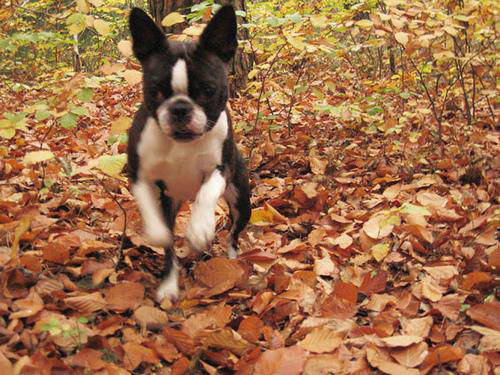

In [10]:
Image.open(PATH+fn)

In [11]:
learn.precompute = False
trn_tfms, val_tfms = tfms_from_model(arch, sz)

## Approach 1

In [12]:
im = val_tfms(open_image(PATH+fn))  #important to use open_image() instead of Open.image() here!
preds = learn.predict_array(im[None])
k = np.argmax(preds)
k, data.classes[k]

(19, 'boston_bull')

## Approach 2

In [24]:
ds = FilesIndexArrayDataset([fn], np.array([0]), val_tfms, PATH)
dl = DataLoader(ds)
preds = learn.predict_dl(dl)
k = np.argmax(preds)
k, data.classes[k]

(19, 'boston_bull')

## Approach 3 (small batches for files for test)

In [33]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH, 'train' ,f'{PATH}labels.csv', test_name='google', 
                                    val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs)
learn.set_data(data)

In [34]:
log_preds, _ = learn.TTA(is_test=True)
probs = np.mean(np.exp(log_preds), 0)

In [35]:
probs.shape

(3, 120)

In [36]:
a,b,c = np.argmax(probs[0]), np.argmax(probs[1]), np.argmax(probs[2])

In [37]:
data.classes[a], data.classes[b], data.classes[c]

('pug', 'norfolk_terrier', 'shih-tzu')

# Dropout

In [14]:
learn2 = ConvLearner.pretrained(arch, data, ps=0.5)

In [15]:
learn2

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (4): Sequential(
    (0): Sequential(
      (0): LambdaMap(
        (0): Sequential(
          (0): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
            (2): ReLU()
            (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
            (5): ReLU()
          )
          (1): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
        )
        (1): Sequential(
          (0): Conv2d(64, 256, kernel

In [16]:
learn2.precompute = True

In [17]:
learn2

Sequential(
  (0): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True)
  (1): Dropout(p=0.5)
  (2): Linear(in_features=4096, out_features=512, bias=True)
  (3): ReLU()
  (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=512, out_features=120, bias=True)
  (7): LogSoftmax()
)

In [22]:
learn2 = ConvLearner.pretrained(arch, data)

In [23]:
learn2.precompute = True

In [24]:
learn2

Sequential(
  (0): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True)
  (1): Dropout(p=0.25)
  (2): Linear(in_features=4096, out_features=512, bias=True)
  (3): ReLU()
  (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=512, out_features=120, bias=True)
  (7): LogSoftmax()
)